# Evaluating a classification model

*From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)*

## Agenda

- What is the purpose of **model evaluation**, and what are some common evaluation procedures?
- What is the usage of **classification accuracy**, and what are its limitations?
- How does a **confusion matrix** describe the performance of a classifier?
- What **metrics** can be computed from a confusion matrix?
- How can you adjust classifier performance by **changing the classification threshold**?
- What is the purpose of an **ROC curve**?
- How does **Area Under the Curve (AUC)** differ from classification accuracy?

## Review of model evaluation

- Need a way to choose between models: different model types, tuning parameters, and features
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requires a **model evaluation metric** to quantify the model performance

### Model evaluation procedures

1. **Training and testing on the same data**
    - Rewards overly complex models that "overfit" the training data and won't necessarily generalize
2. **Train/test split**
    - Split the dataset into two pieces, so that the model can be trained and tested on different data
    - Better estimate of out-of-sample performance, but still a "high variance" estimate
    - Useful due to its speed, simplicity, and flexibility
3. **K-fold cross-validation**
    - Systematically create "K" train/test splits and average the results together
    - Even better estimate of out-of-sample performance
    - Runs "K" times slower than train/test split

### Model evaluation metrics

- **Regression problems:** Mean Absolute Error, Mean Squared Error, Root Mean Squared Error
- **Classification problems:** Classification accuracy

There are many other important metrics for classification problems, and those metrics are the topic of this session.

## Classification accuracy

[Pima Indian Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) from the UCI Machine Learning Repository

In [1]:
# read the data into a Pandas DataFrame
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names)

In [2]:
# print the first 5 rows of data
pima.head()

pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  label
0         6      148  72    35        0  33.6     0.627   50      1
1         1       85  66    29        0  26.6     0.351   31      0
2         8      183  64     0        0  23.3     0.672   32      1
3         1       89  66    23       94  28.1     0.167   21      0
4         0      137  40    35      168  43.1     2.288   33      1

- Each row represents one patient.
- `label` column indicates whether patient has diabetes or not (1 = yes, 0 = no)

We are defining the classification problem as follows :-

**Question:** Can we predict the diabetes status of a patient given their health measurements?

In [3]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

In [4]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

C:\Users\Honey\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [7]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333


- The above accuracy is pretty good.
- **However**, anytime you use classification accuracy as your evaluation metric, it is important to compare it with Null Accuracy, which is the accuracy that can be achieved by always predicting the most frequent class in testing set

**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [8]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

In [9]:
# calculate the percentage of ones
y_test.mean()

0.3229166666666667

In [11]:
# calculate the percentage of zeros
1 - y_test.mean()

0.6770833333333333

In [12]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.6770833333333333

In [13]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
Name: label, dtype: float64

- ~68% is the Null Accuracy for this problem
- In other words, a dumb model that always predict that a patient does not have diabetes will be right 68% of the time.
- This is obviously not a useful model, but it provides a baseline against which we might want to measure our logistic regression model.
- When we compare the Null Accuracy of 68% with model accuracy of 69%, suddenly our model does not look very good.
- This demonstrates one weakness of classification accuracy as a model evaluation metric, that the **classification accuracy does not tell us anything about the underlying distribution of the testing set**.

Comparing the **true** and **predicted** response values

In [14]:
# print the first 25 true and predicted responses
from __future__ import print_function
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


- In the above case we can see that when the true response value is 0, the model almost always predict a 0. Whereas when the true response value is a 1, the model rarely predicts a 1.
- In other words, the model is usually making a certain type of errors but not others, but we may never know that simply by examining the accuracy.
- This is another weakness of classification accuracy.
- This weakness is overcome using **Confusion matrix** discussed next.

**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
- And, it does not tell you what **"types" of errors** your classifier is making

## Confusion matrix

Table that describes the performance of a classification model

- The **confusion_matrix()** function is also available in the **metrics** module.
- **NOTE :- ** when using the confusion matrix always pass the true response as the first argument and the predicted response as the second argument. It's a good habit to adapt regardless of whether the order matters(eg. accuracy), to always pass the true value as first argument and predicted value as second argument.

In [16]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[118  12]
 [ 47  15]]


![Small confusion matrix](images/09_confusion_matrix_1.png)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal, as sometimes the position of true and predicted values are reversed so pay attention to the format.

- Its conventional to denote the class denoted by 1 as the positive class and class denoted by 0 as a negative class.
- That is why correctly predicting a 1 value is **True Positive** and correctly predicting a 0 is a **True Negative**.
- **False Positives** are known in some fields as **Type 1 errors**
- **False Negatives** are known in some fields as **Type 2 errors**

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error")
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error")

In [17]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

![Large confusion matrix](images/09_confusion_matrix_2.png)

## Metrics computed from a confusion matrix

- The confusion matrix is useful for you to understand the performance of your classifier.
- But, Confusion matrix is not a model evaluation metric and so we can't simply tell scikit-learn to choose the model with best confusion matrix.
- However, there are many metrics that can be calculated from the confusion matrix and those can be directly used to choose between models.

**Classification Accuracy:** Overall, how often is the classifier correct?

$$Classification\ Accuracy = \frac {TP+TN} {total\ observations}$$

It can also be calculated from **sklearn** using **metrics** module's **accuracy_score()** function

In [19]:
print((TP + TN) / float(TP + TN + FP + FN))         # Converting to float to do true division instead of integer division
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333
0.692708333333


**Classification Error:** Overall, how often is the classifier incorrect?

- Also known as "**Misclassification Rate**"

$$Classification\ Error = \frac {FP+FN} {total\ observations}$$

i.e (1 - Classification Accuracy)

In [20]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.307291666667
0.307291666667


**Sensitivity:** When the actual value is positive, how often is the prediction correct?

- How "**sensitive**" is the classifier to detecting positive instances?
- Also known as "**True Positive Rate**" or "**Recall**"
- Sensitivity is something that we want to maximize.

$$ Sensitivity = \frac {TP} {TP+FN} $$

**sklearn.metrics** module also provides a method **recall_score()** to calculate the sensitivity or recall

In [21]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.241935483871
0.241935483871


**Specificity:** When the actual value is negative, how often is the prediction correct?

- How "specific" (or "selective") is the classifier in predicting positive instances?
- Similar to sensitivity, Specificity is also something we want to maximize
- There is no inbuilt metric function in sklearn to calculate specificity

$$ Specificity = \frac {TN} {TN + FP}$$

In [22]:
print(TN / float(TN + FP))

0.907692307692


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

$$ False\ Positive\ Rate = \frac {FP} {TN + FP}$$

or simply (1 - Specificity)

We want this metric to be minimized.

In [23]:
print(FP / float(TN + FP))

0.0923076923077


**Precision:** When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?
- **sklearn.metrics** module has a function **precision_score()** to calculate precision

$$ Precision = \frac {TP} {TP + FP}$$

In [24]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.555555555556
0.555555555556


**Note :- **Many other metrics can be computed from confusion matrix such as the **F1 score**, **Matthews correlation coefficient**, etc.

**Conclusion:**

- Advisable to always compute the confusion matrix for your classifier.
- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection
- However we can't optimize the model for each of the metric, so we have to choose between them.

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**. Check below two examples :-

**Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)

**Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

## Adjusting the classification threshold

In [26]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1], dtype=int64)

- a similar method called **predict_proba()** gives the predicted probabilities of class membership
- Each row is one observation and each column represents a particular class, and shows the probability of observation to belong to that class.
- The **predict()** method first predicts the probabilities for each class for any observation and then selects the class with the highest probability as the class for that observation.
- For a binary problem like this one, another way of thinking about this is that there is a classification threshold of 0.5. Only if that threshold is exceeded then class 1 is predicted, otherwise class 0 is predicted.

In [27]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10, :]

array([[ 0.63247571,  0.36752429],
       [ 0.71643656,  0.28356344],
       [ 0.71104114,  0.28895886],
       [ 0.5858938 ,  0.4141062 ],
       [ 0.84103973,  0.15896027],
       [ 0.82934844,  0.17065156],
       [ 0.50110974,  0.49889026],
       [ 0.48658459,  0.51341541],
       [ 0.72321388,  0.27678612],
       [ 0.32810562,  0.67189438]])

In [28]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

In [29]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

- Plotting a histogram of these probabilities can help us see the effect of changing the classification threshold on performance of the model.
- The histogram shows the distribution of a numerical variable.

In [30]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

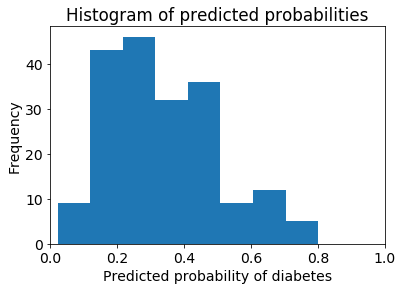

In [31]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

- We can see from the above histogram that only a small portion of observations from testing set are predicted as positive (i.e. with probability more than 0.5)
- We can adjust both the sensitivity and specificity of a classifier simply by adjusting the threshold.

**Decrease the threshold** for predicting diabetes in order to **increase the sensitivity** of the classifier

- This increases sensitivity because the classifier is now more sensitive to positive instances, because now more instances will be classified as positive.
- Eg. A **Metal detector** is essentially a classifier which predicts metal and a threshold is set so that large metal objects set off the detector but tiny ones do not. To increase the sensitivity of the metal detector, you have to **decrease** the threshold (i.e. the amount of metal that is required to set it off), and thus it is now more sensitive to metal and will predict yes more often.

- **sklearn.preprocessing** module has a **binarize()** function that can be given the threshold for converting all values above threshold to 1 and 0 otherwise.

In [36]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.3)[0]

In [37]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

In [38]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.])

In [39]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[118  12]
 [ 47  15]]


In [40]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[80 50]
 [16 46]]


In [41]:
# sensitivity has increased (used to be 0.24)
print(46 / float(46 + 16))

0.7419354838709677


In [42]:
# specificity has decreased (used to be 0.91)
print(80 / float(80 + 50))

0.6153846153846154


### Conclusion

- **Threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions
- Threshold can be **adjusted** to increase sensitivity or specificity depending on your business objective.
- Sensitivity and specificity have an **inverse relationship**
- **Note :-** Adjusting the threshold is one of the last step in the model building process. The majority of the time should be focussed on building better models and then selecting the best possible model.

## ROC Curves and Area Under the Curve (AUC)

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve!

- The ROC curve is a plot of the True Positive Rate (tpr) on the Y-axis against the False Positive Rate (fpr) on the X-axis for all possible classification thresholds from 0 to 1.
- So, Y-axis is Sensitivity and X-axis is (1-Specificity)
- **sklearn.metrics** module provides the method **roc_curve()**
- We pass it the true values for the testing set and the predicted probabilities for class 1 for each observation.
    - **Note -** It is critically important that you use predicted probabilities and not the predicted class.
- It returns three objects - **fpr**, **tpr** and **thresholds**

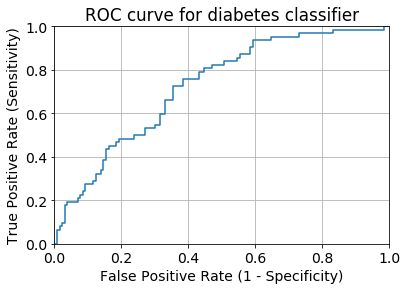

In [43]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

- The optimal ROC curve would meet the upper left corner of the plot, since that would represent a classifier with high sensitivity and high specificity.
- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself
    - Below is a small helper function that allows you to pass-in a threshold value and see the sensitivity and specificity at that threshold.

In [44]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [45]:
evaluate_threshold(0.5)

Sensitivity: 0.241935483871
Specificity: 0.907692307692


In [47]:
evaluate_threshold(0.3)

Sensitivity: 0.725806451613
Specificity: 0.615384615385


- Given a particular point on the ROC curve it would a simple trial-and-error process to locate the threshold that produced that point.

AUC is the **percentage** of the ROC plot that is **underneath the curve**:

Because an ideal classifier hugs the upper left corner of the plot, a higher AUC value indicates a better overall classifier.
- Best possible AUC for any classifier is **1.0**
- **sklearn.metrics** module has function **roc_auc_score()** to calculate the AUC for the ROC curve
    - Once again we pass in the true response values as first argument and the predicted probabilities as second argument (not the predicted classes)

In [50]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.724565756824


- AUC is often used as a **single number summary** of classifier performance as an alternative to classification accuracy.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy).

- Because AUC is a useful metric for choosing between models, it is available as a scoring function for **cross_val_score()**

In [52]:
# calculate cross-validated AUC
from sklearn.cross_validation import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.73782336182336183

**Confusion matrix advantages:**

- Allows you to calculate a **variety of metrics**
- Useful for **multi-class problems** (more than two response classes)

**ROC/AUC advantages:**

- Does not require you to **set a classification threshold** unlike the confusion matrix.
- Still useful when there is **high class imbalance**
- However, they are less interpretable than confusion matrix for multi-class problems.

## Confusion Matrix Resources

- Blog post: [Simple guide to confusion matrix terminology](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by me
- Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes) by Rahul Patwari
- Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix (by Ed Podojil)
- Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)


## ROC and AUC Resources

- Lesson notes: [ROC Curves](http://ebp.uga.edu/courses/Chapter%204%20-%20Diagnosis%20I/8%20-%20ROC%20curves.html) (from the University of Georgia)
- Video: [ROC Curves and Area Under the Curve](https://www.youtube.com/watch?v=OAl6eAyP-yo) (14 minutes) by me, including [transcript and screenshots](http://www.dataschool.io/roc-curves-and-auc-explained/) and a [visualization](http://www.navan.name/roc/)
- Video: [ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4) (12 minutes) by Rahul Patwari
- Paper: [An introduction to ROC analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf) by Tom Fawcett
- Usage examples: [Comparing different feature sets](http://research.microsoft.com/pubs/205472/aisec10-leontjeva.pdf) for detecting fraudulent Skype users, and [comparing different classifiers](http://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets

## Other Resources

- scikit-learn documentation: [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html)
- Guide: [Comparing model evaluation procedures and metrics](https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md) by me
- Video: [Counterfactual evaluation of machine learning models](https://www.youtube.com/watch?v=QWCSxAKR-h0) (45 minutes) about how Stripe evaluates its fraud detection model, including [slides](http://www.slideshare.net/MichaelManapat/counterfactual-evaluation-of-machine-learning-models)

## Comments or Questions?

- Email: <kevin@dataschool.io>
- Website: http://dataschool.io
- Twitter: [@justmarkham](https://twitter.com/justmarkham)

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()